In [1]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download samuelcortinhas/sports-balls-multiclass-image-classification

Dataset URL: https://www.kaggle.com/datasets/samuelcortinhas/sports-balls-multiclass-image-classification
License(s): CC0-1.0
 95% 382M/401M [00:00<00:00, 500MB/s]
100% 401M/401M [00:00<00:00, 523MB/s]


In [ ]:
!unzip /content/sports-balls-multiclass-image-classification.zip -d /content/

In [4]:
#Import the packages
import tensorflow as tf
from tensorflow.keras import layers,models
from tensorflow.keras.layers import Rescaling

import os

import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd



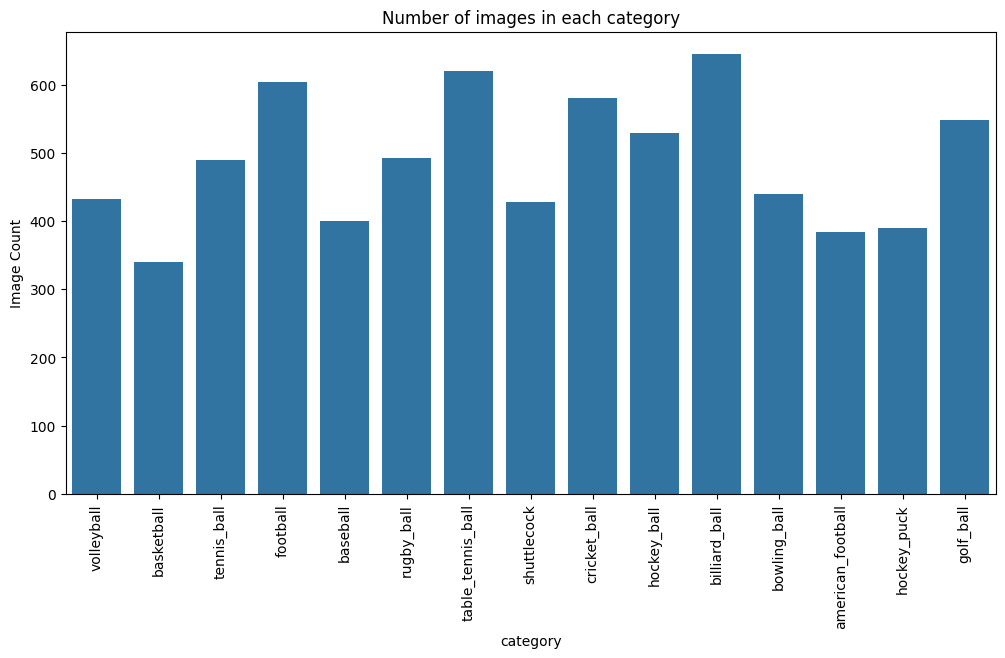

In [5]:

train_dir='/content/train'

#dictionary to store subdirectory names and file counts!
data={'category':[],'Image Count':[]}

#Loop through each subdirectory
for sub_dir in os.listdir(train_dir):
  sub_dir_path=os.path.join(train_dir,sub_dir)#to create the full path to look inside eg. '/content/train/baseball'
  if os.path.isdir(sub_dir_path):# checking if it is really a folder
    #Count the number of files(Images) in the subdirectory
    num_files=len([f for f in os.listdir (sub_dir_path) if os.path.isfile(os.path.join(sub_dir_path,f))])
    #it will look inside every file and iterate through everything inside it and will join it to the parent path and will check if it is a file and will make a list of these files
    #len function will count the no. of files in that list
    data['category'].append(sub_dir)#will have class names
    data['Image Count'].append(num_files)#no. of images for each category

#convert the data to dataframe
df=pd.DataFrame(data)

plt.figure(figsize=(12,6))
sns.barplot(x='category',y='Image Count',data=df)
plt.xticks(rotation=90)
plt.title('Number of images in each category')
plt.ylabel('Image Count')
plt.xlabel('category')
plt.show()


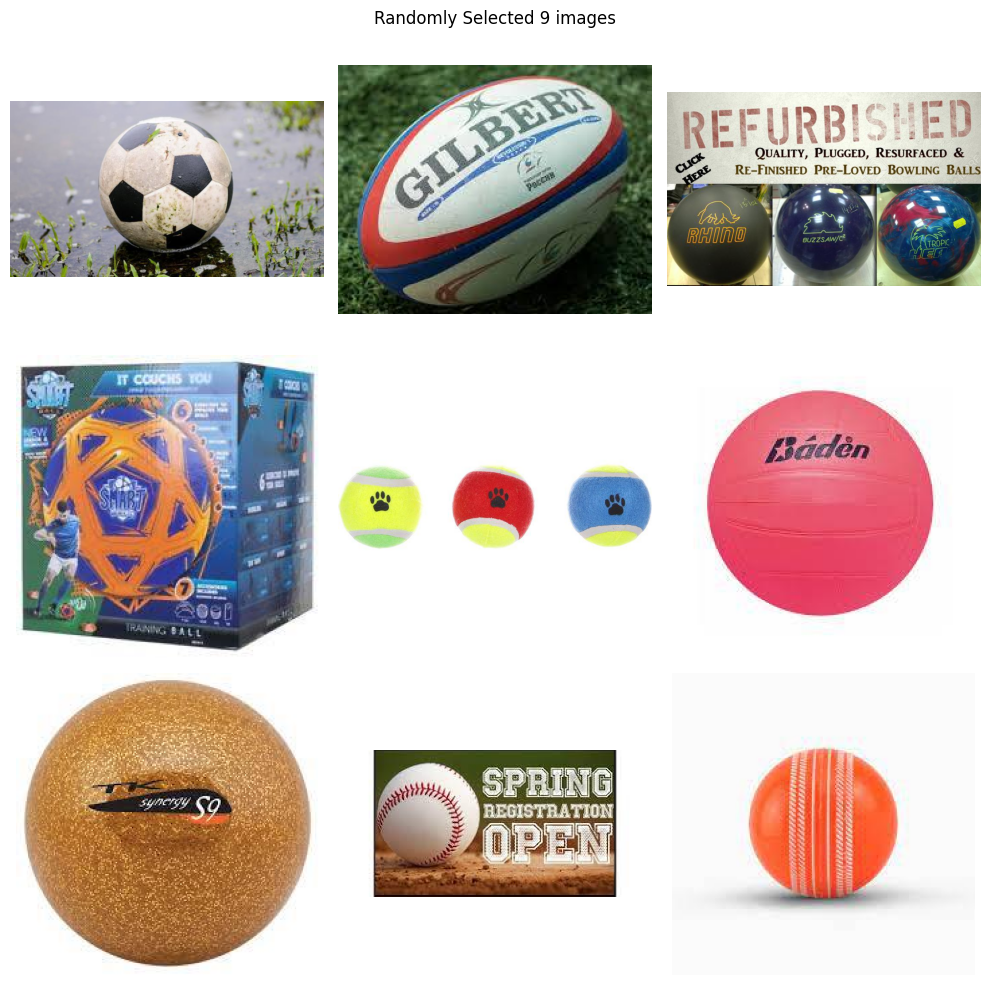

In [6]:
import random
import matplotlib.image as mpimg
all_images=[]
for sub_dir in os.listdir(train_dir):
  sub_dir_path=os.path.join(train_dir,sub_dir)
  if os.path.isdir(sub_dir_path):
    all_images.extend([os.path.join(sub_dir_path,f) for f in os.listdir(sub_dir_path) if os.path.isfile(os.path.join(sub_dir_path,f))])
random_images=random.sample(all_images,9)

plt.figure(figsize=(10,10))

for i,image_path in enumerate(random_images):
  img=mpimg.imread(image_path)
  plt.subplot(3,3,i+1)
  plt.imshow(img)
  plt.axis('off')
plt.suptitle('Randomly Selected 9 images')
plt.tight_layout()
plt.show()

In [7]:
#Data Preparation
img_size=(224,224)#resNet standard input size
batch_size=32

#Data Augmentation
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip(['Horizontal']),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

#Load Dataset
train_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed=123, #for reproducibility
    image_size=img_size,
    batch_size=batch_size
)

val_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed=123, #for reproducibility
    image_size=img_size,
    batch_size=batch_size
)

#Apply Data Augmentation On trianing data
train_dataset=train_dataset.map(lambda x,y:(data_augmentation(x,training=True),y))

#Prefetch the data for performance
AUTOTUNE=tf.data.AUTOTUNE # thsi will check how much ram and cpu cores i have and will decide the optimal buffersize
train_dataset=train_dataset.prefetch(buffer_size=AUTOTUNE)# this will create the buffer for training
val_dataset=val_dataset.prefetch(buffer_size=AUTOTUNE)



Found 7328 files belonging to 15 classes.
Using 5863 files for training.
Found 7328 files belonging to 15 classes.
Using 1465 files for validation.


In [8]:
def residual_block(x,filters,kernel_size=3,strides=1):
  shortcut=x

  #First 1 x 1 convolution to reduce the dimension
  x=layers.Conv2D(filters,kernel_size=1,strides=1,padding='same')(x)
  x=layers.BatchNormalization()(x)
  x=layers.Activation('relu')(x)

  #3 x 3 Convolution layer
  x=layers.Conv2D(filters,kernel_size=kernel_size,strides=strides,padding='same')(x)
  x=layers.BatchNormalization()(x)
  x=layers.Activation('relu')(x)

  #1 x 1 Convolutiion to restore dimensions
  x=layers.Conv2D(filters*4,kernel_size=1,strides=1,padding='same')(x)
  x=layers.BatchNormalization()(x)

  #Shortcut Connection(Adjust dimension if necessary)
  if strides !=1 or shortcut.shape[-1]!=(filters*4):
    shortcut=layers.Conv2D(filters*4,kernel_size=1,strides=strides,padding='same')(shortcut)
    shortcut=layers.BatchNormalization()(shortcut)

  #Add the shortcut
  x=layers.Add()([x,shortcut])
  x=layers.Activation('relu')(x)

  return x

In [9]:
def build_resNet50(input_shape=(224,224,3),num_classes=5):
  inputs=tf.keras.Input(shape=input_shape)

  x=layers.Rescaling(1./255)(inputs)

  #Initial Convolution layer
  x=layers.Conv2D(64,kernel_size=7,strides=2,padding='same')(x)
  x=layers.BatchNormalization()(x)
  x=layers.MaxPooling2D(pool_size=3,strides=2,padding='same')(x)

  #Residual Blocks(Bottleneck Architecture)
  x=residual_block(x,filters=64)
  x=residual_block(x,filters=64)
  x=residual_block(x,filters=64)

  x=residual_block(x,filters=128,strides=2)
  x=residual_block(x,filters=128)
  x=residual_block(x,filters=128)
  x=residual_block(x,filters=128)

  x=residual_block(x,filters=256,strides=2)
  x=residual_block(x,filters=256)
  x=residual_block(x,filters=256)
  x=residual_block(x,filters=256)
  x=residual_block(x,filters=256)
  x=residual_block(x,filters=256)

  x=residual_block(x,filters=512,strides=2)
  x=residual_block(x,filters=512)
  x=residual_block(x,filters=512)

  #Global Average Pooling and Output
  x=layers.GlobalAveragePooling2D()(x)
  x=layers.Dense(512,activation='relu')(x)
  x=layers.Dense(num_classes,activation='softmax')(x)

  model=models.Model(inputs,x)

  return model









In [21]:
model=build_resNet50(input_shape=(224,224,3),num_classes=15)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 112, 112,  │      9,472 │ rescaling_1[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_53[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 56, 56,    │      4,160 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_54[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_48       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 56, 56,    │     36,928 │ activation_48[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_55[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_49       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 56, 56,    │     16,640 │ activation_49[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 56, 56,    │     16,640 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_56[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_57[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_50       │ (None, 56, 56,    │          0 │ add_16[0][0]    

 Total params: 24,644,495 (94.01 MB)

 Trainable params: 24,591,375 (93.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [22]:
#compile the model
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])

In [23]:
#Train the Model
history=model.fit(train_dataset,validation_data=val_dataset,epochs=10)

Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 169s 612ms/step - accuracy: 0.1389 - loss: 2.7867 - val_accuracy: 0.0778 - val_loss: 3.5360
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 82s 442ms/step - accuracy: 0.2470 - loss: 2.3942 - val_accuracy: 0.0819 - val_loss: 3.7710
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 85s 456ms/step - accuracy: 0.3137 - loss: 2.1917 - val_accuracy: 0.2218 - val_loss: 2.7089
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 83s 451ms/step - accuracy: 0.3596 - loss: 2.0442 - val_accuracy: 0.2491 - val_loss: 2.3529
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 77s 418ms/step - accuracy: 0.3860 - loss: 1.9606 - val_accuracy: 0.3270 - val_loss: 2.2207
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 80s 409ms/step - accuracy: 0.4246 - loss: 1.8618 - val_accuracy: 0.2594 - val_loss: 2.8959
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 75s 406ms/step - accuracy: 0.4434 - loss: 1.7681 - val_accuracy: 0.2655 - val_loss: 2.7348
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 75s 408ms/step - accuracy: 0.4593 - loss: 

In [25]:
test_dir='/content/test'
test_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(224,224),
    batch_size=32,
    labels='inferred',
    label_mode='categorical',

)

Found 1841 files belonging to 15 classes.


In [26]:
test_loss,test_accuracy=model.evaluate(test_dataset)
print(f"test_accuracy: {test_accuracy*100:.2f}%")

58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - accuracy: 0.4162 - loss: 1.9470
test_accuracy: 42.04%


In [27]:
#Transfer Learning


#Loading the pretrained model
base_model=tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_tensor=tf.keras.layers.Input(shape=(224,224,3))
)
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [28]:
#Freeze the base model
for layer in base_model.layers:
  layer.trainable=False

In [29]:
#Build the model

x=base_model.output
x=layers.GlobalAveragePooling2D()(x)
x=layers.Dense(512,activation='relu')(x)
x=layers.Dropout(0.5)(x)
x=layers.Dense(15,activation='softmax')(x)
model=models.Model(base_model.input,x)
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,644,495 (94.01 MB)

 Trainable params: 1,056,783 (4.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [30]:
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])

In [31]:
history1=model.fit(train_dataset,validation_data=val_dataset,epochs=10)

Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 87s 415ms/step - accuracy: 0.2397 - loss: 2.6505 - val_accuracy: 0.6689 - val_loss: 1.2101
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 65s 347ms/step - accuracy: 0.5908 - loss: 1.3421 - val_accuracy: 0.7283 - val_loss: 0.9452
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 65s 351ms/step - accuracy: 0.6772 - loss: 1.0702 - val_accuracy: 0.7563 - val_loss: 0.8389
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 63s 342ms/step - accuracy: 0.7243 - loss: 0.9151 - val_accuracy: 0.7652 - val_loss: 0.7813
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 63s 343ms/step - accuracy: 0.7466 - loss: 0.8166 - val_accuracy: 0.7741 - val_loss: 0.7497
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 64s 346ms/step - accuracy: 0.7760 - loss: 0.7246 - val_accuracy: 0.7795 - val_loss: 0.7167
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 65s 350ms/step - accuracy: 0.7934 - loss: 0.6708 - val_accuracy: 0.7932 - val_loss: 0.6877
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 81s 343ms/step - accuracy: 0.8124 - loss: 0

In [32]:
test_loss,test_accuracy=model.evaluate(test_dataset)
print(f"test_accuracy: {test_accuracy*100:.2f}%")

58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.8157 - loss: 0.6567
test_accuracy: 81.31%


In [36]:
#Finetuning
count=0
for layer in base_model.layers:
  if count<41:
    layer.trainable=False
  else:
    layer.trainable=True
  count+=1


In [37]:
#Build the model

x=base_model.output
x=layers.GlobalAveragePooling2D()(x)
x=layers.Dense(512,activation='relu')(x)
x=layers.Dropout(0.5)(x)
x=layers.Dense(15,activation='softmax')(x)
model=models.Model(base_model.input,x)
model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,644,495 (94.01 MB)

 Trainable params: 24,331,407 (92.82 MB)

 Non-trainable params: 313,088 (1.19 MB)

In [38]:
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])

In [39]:
history2=model.fit(train_dataset,validation_data=val_dataset,epochs=10)

Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 136s 512ms/step - accuracy: 0.4499 - loss: 1.8259 - val_accuracy: 0.8068 - val_loss: 0.6552
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 69s 374ms/step - accuracy: 0.8259 - loss: 0.5882 - val_accuracy: 0.8389 - val_loss: 0.5418
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 70s 376ms/step - accuracy: 0.8914 - loss: 0.3554 - val_accuracy: 0.8294 - val_loss: 0.6414
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 70s 379ms/step - accuracy: 0.9269 - loss: 0.2499 - val_accuracy: 0.8355 - val_loss: 0.6278
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 71s 383ms/step - accuracy: 0.9329 - loss: 0.2128 - val_accuracy: 0.8532 - val_loss: 0.5828
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 70s 378ms/step - accuracy: 0.9436 - loss: 0.1845 - val_accuracy: 0.8717 - val_loss: 0.5126
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 70s 379ms/step - accuracy: 0.9453 - loss: 0.1710 - val_accuracy: 0.8669 - val_loss: 0.5950
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 83s 382ms/step - accuracy: 0.9638 - loss: 

In [40]:
test_loss,test_accuracy=model.evaluate(test_dataset)
print(f"test_accuracy: {test_accuracy*100:.2f}%")

58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.8357 - loss: 0.7182
test_accuracy: 83.92%
